In [1]:
from google.colab import  files
uploaded = files.upload()




Saving kaggle.json to kaggle (3).json


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("javariatahir/litstrain-val")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1


In [4]:
import os

path = "/root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1/LiTS(train_test)"   # غير المسار حسب اللي انت عايزه

print(f"Contents of: {path}")
for item in os.listdir(path):
    print(item)



Contents of: /root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1/LiTS(train_test)
test_mask
test_CT
train_mask
train_CT


In [5]:
import os

BASE_PATH = "/root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1/LiTS(train_test)"

print("Contents of BASE_PATH:")
for item in os.listdir(BASE_PATH):
    print("📁", item)


Contents of BASE_PATH:
📁 test_mask
📁 test_CT
📁 train_mask
📁 train_CT


In [6]:
import os

for folder in os.listdir(BASE_PATH):
    folder_path = os.path.join(BASE_PATH, folder)
    print(f"\n📂 {folder}")

    if os.path.isdir(folder_path):
        files = os.listdir(folder_path)
        print(f"عدد الملفات: {len(files)}")
        for f in files[:5]:
            print("   📄", f)



📂 test_mask
عدد الملفات: 20
   📄 segmentation-115.nii
   📄 segmentation-120.nii
   📄 segmentation-129.nii
   📄 segmentation-125.nii
   📄 segmentation-130.nii

📂 test_CT
عدد الملفات: 20
   📄 volume-112.nii
   📄 volume-119.nii
   📄 volume-117.nii
   📄 volume-126.nii
   📄 volume-120.nii

📂 train_mask
عدد الملفات: 111
   📄 segmentation-30.nii
   📄 segmentation-99.nii
   📄 segmentation-68.nii
   📄 segmentation-33.nii
   📄 segmentation-26.nii

📂 train_CT
عدد الملفات: 111
   📄 volume-32.nii
   📄 volume-37.nii
   📄 volume-13.nii
   📄 volume-2.nii
   📄 volume-16.nii


In [7]:
train_ct   = os.path.join(BASE_PATH, "train_CT")
train_mask = os.path.join(BASE_PATH, "train_mask")

test_ct    = os.path.join(BASE_PATH, "test_CT")
test_mask  = os.path.join(BASE_PATH, "test_mask")

print("Train CT samples :", len(os.listdir(train_ct)))
print("Train Mask samples:", len(os.listdir(train_mask)))
print("Test CT samples  :", len(os.listdir(test_ct)))
print("Test Mask samples :", len(os.listdir(test_mask)))


Train CT samples : 111
Train Mask samples: 111
Test CT samples  : 20
Test Mask samples : 20


In [8]:
# -- استيراد المكتبات --
import os
import numpy as np
import nibabel as nib
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [9]:
# حدد المسار على جوجل درايف حيث توجد ملفات البيانات
BASE_PATH = "/root/.cache/kagglehub/datasets/javariatahir/litstrain-val/versions/1/LiTS(train_test)"

TRAIN_CT   = os.path.join(BASE_PATH, "train_CT")
TRAIN_MASK = os.path.join(BASE_PATH, "train_mask")
TEST_CT    = os.path.join(BASE_PATH, "test_CT")
TEST_MASK  = os.path.join(BASE_PATH, "test_mask")

IMG_SIZE = 128
BATCH_SIZE = 4


In [10]:
# ---- دالة لتحميل الصور وتطبيعها ----
def load_nii(path):
    img = nib.load(path).get_fdata()
    img = img.astype(np.float32)
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)
    return img

In [11]:
# ---- دالة لتحميل الماسك وتحويله ل binary (ورم فقط) ----
def load_mask_binary(path):
    mask = nib.load(path).get_fdata()
    # تحويل: كل مكان قيمته 2 (ورم) يصبح 1، والباقي 0
    binary_mask = (mask == 2).astype(np.float32)
    return binary_mask

In [12]:
def data_generator(ct_path, mask_path, batch_size=BATCH_SIZE):

    ct_files = sorted(os.listdir(ct_path))

    while True:
        np.random.shuffle(ct_files)

        for i in range(0, len(ct_files), batch_size):
            X, Y = [], []

            for ct_file in ct_files[i:i+batch_size]:

                idx = ct_file.split("-")[1].split(".")[0]
                mask_file = f"segmentation-{idx}.nii"

                ct_file_path = os.path.join(ct_path, ct_file)
                mask_file_path = os.path.join(mask_path, mask_file)

                if not os.path.exists(mask_file_path):
                    continue

                ct = nib.load(ct_file_path).get_fdata()
                mask = nib.load(mask_file_path).get_fdata()

                slice_idx = ct.shape[2] // 2

                ct_slice = ct[:, :, slice_idx]
                mask_slice = mask[:, :, slice_idx]

                ct_slice = cv2.resize(ct_slice, (IMG_SIZE, IMG_SIZE))
                mask_slice = cv2.resize(
                    mask_slice,
                    (IMG_SIZE, IMG_SIZE),
                    interpolation=cv2.INTER_NEAREST
                )

                ct_slice = ct_slice / np.max(ct_slice)
                mask_slice = (mask_slice > 0).astype(np.float32)

                X.append(ct_slice[..., np.newaxis])
                Y.append(mask_slice[..., np.newaxis])

            if len(X) > 0:
                yield np.array(X), np.array(Y)


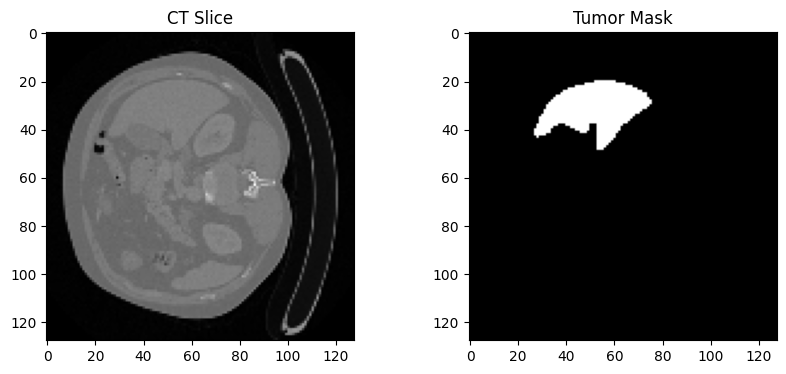

In [13]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
train_gen = data_generator(TRAIN_CT, TRAIN_MASK)
X, Y = next(train_gen)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(X[0].squeeze(), cmap="gray")
plt.title("CT Slice")

plt.subplot(1,2,2)
plt.imshow(Y[0].squeeze(), cmap="gray")
plt.title("Tumor Mask")
plt.show()


In [14]:
inputs = Input((IMG_SIZE, IMG_SIZE, 1))

c1 = Conv2D(16, 3, activation="relu", padding="same")(inputs)
c1 = Conv2D(16, 3, activation="relu", padding="same")(c1)
p1 = MaxPooling2D()(c1)

c2 = Conv2D(32, 3, activation="relu", padding="same")(p1)
c2 = Conv2D(32, 3, activation="relu", padding="same")(c2)
p2 = MaxPooling2D()(c2)

c3 = Conv2D(64, 3, activation="relu", padding="same")(p2)

u1 = UpSampling2D()(c3)
u1 = Concatenate()([u1, c2])
c4 = Conv2D(32, 3, activation="relu", padding="same")(u1)

u2 = UpSampling2D()(c4)
u2 = Concatenate()([u2, c1])
c5 = Conv2D(16, 3, activation="relu", padding="same")(u2)

outputs = Conv2D(1, 1, activation="sigmoid")(c5)

model = Model(inputs, outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     27,680 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 48)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │      6,928 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │         17 │ conv2d_6[0][0]    │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,489 (271.44 KB)

 Trainable params: 69,489 (271.44 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


In [16]:
model.compile(
    optimizer="adam",
    loss=dice_loss,
    metrics=[dice_coefficient]
)


In [17]:
model.fit(
    train_gen,
    steps_per_epoch=25,
    epochs=10
)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 203s 8s/step - dice_coefficient: 0.1153 - loss: 0.8847
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 219s 9s/step - dice_coefficient: 0.5543 - loss: 0.4455
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 211s 8s/step - dice_coefficient: 0.5010 - loss: 0.5034
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 209s 8s/step - dice_coefficient: 0.5997 - loss: 0.4022
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 203s 8s/step - dice_coefficient: 0.6193 - loss: 0.3824
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 223s 8s/step - dice_coefficient: 0.6022 - loss: 0.3988
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 223s 9s/step - dice_coefficient: 0.4558 - loss: 0.5443
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 211s 9s/step - dice_coefficient: 0.6469 - loss: 0.3534
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 191s 7s/step - dice_coefficient: 0.6281 - loss: 0.3725
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 209s 9s/step - dice_coefficient: 0.5032 - loss: 0.4968


In [18]:
test_gen = data_generator(TEST_CT, TEST_MASK)

results = model.evaluate(test_gen, steps=10)
print(f"Test Dice Score: { results[1]*100:.1f} %")


10/10 ━━━━━━━━━━━━━━━━━━━━ 88s 10s/step - dice_coefficient: 0.6795 - loss: 0.3205
Test Dice Score: 70.2 %


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


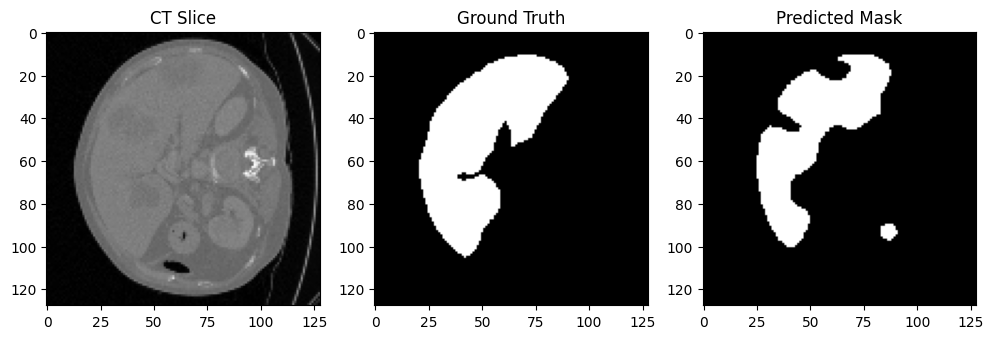

In [19]:
X_test, Y_test = next(test_gen)
pred = model.predict(X_test)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(X_test[0].squeeze(), cmap="gray")
plt.title("CT Slice")

plt.subplot(1,3,2)
plt.imshow(Y_test[0].squeeze(), cmap="gray")
plt.title("Ground Truth")

plt.subplot(1,3,3)
plt.imshow(pred[0].squeeze() > 0.5, cmap="gray")
plt.title("Predicted Mask")

plt.show()


In [20]:
model.save("final_liver_unet.keras")
